# Paso 6 - Train unificado (dataset + entrenamiento)

**Flujo**: A partir de `data/interim/` se crea el dataset wide de train (todas las fechas de corte con inspecciones ≤ CUTOFF), se cargan features e hiperparámetros desde **models/**, se entrena LGBM, se calibra (isotonic, cv=5) y se guarda el modelo calibrado en **models/**.

- **Input**: `data/interim/` (parquets), `models/features.pkl`, `models/hyperparams.pkl` (ya creados en desarrollo).
- **Output**: `data/processed/train/cutoff=<CUTOFF>/train_wide.parquet` (generado aquí) y **models/lgbm_model_cal.pkl**.

---
## 1. Imports y path del proyecto

Se agrega la raíz del proyecto a `sys.path` para importar `src` y las funciones de creación de dataset.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data.make_dataset import create_train_dataset
from src.modeling.supervised_models import LGBMModel
from src.modeling.helpers import save_model
from sklearn.calibration import CalibratedClassifierCV

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

---
## 2. Configuración

Rutas y parámetros de train se leen de **config/config.yaml** (paths, train.cutoff, train.cant_periodos, sam_th, etc.). Features e hiperparámetros se cargan desde **models/**.

**CUTOFF**: fecha tope de inspecciones. Se consideran **todos** los meses en que hay inspecciones hasta esa fecha (no solo ese mes). Para cada mes se arman filas: contratos inspeccionados ese mes + 12 meses de consumo anteriores + target de esa inspección; luego se concatenan en un solo dataset.

In [2]:
# Cargar configuración desde config/config.yaml
from src.config import load_config, get_paths

cfg = load_config()
paths = get_paths(cfg)
INTERIM_DIR = paths["interim"]
PROCESSED_DIR = paths["processed"]
MODELS_DIR = paths["models"]

t = cfg["train"]
CUTOFF = t["cutoff"]
CANT_PERIODOS = t["cant_periodos"]
SAM_TH = t["sam_th"]
PARAM_IMB_METHOD = t["param_imb_method"]
PREPROCESOR_NUM = t["preprocesor_num"]


---
## 3. Crear dataset de train

Se construye el dataset wide a partir de interim (misma lógica que `2_dataset_creation.ipynb` en modo train). El parquet se guarda en `data/processed/train/cutoff=<CUTOFF>/` y se usa el dataframe en memoria para entrenar.

In [3]:
%%time
df = create_train_dataset(
    INTERIM_DIR, PROCESSED_DIR,
    cant_periodos=CANT_PERIODOS,
    cutoff_max=CUTOFF
)
if df is None:
    raise RuntimeError("No se pudo crear el dataset de train.")
df.rename(columns={"is_fraud": "target"}, inplace=True)
print(f"Train: {len(df)} filas, target mean = {df['target'].mean():.4f}")

Train dataset: 100%|██████████| 44/44 [00:40<00:00,  1.10it/s]


*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Train: 13286 filas, target mean = 0.3483
CPU times: total: 3min 11s
Wall time: 6min 12s


---
## 4. Cargar features e hiperparámetros desde models/

Se cargan **cols_for_model** y **HYPERPARAMS** desde `models/features.pkl` y `models/hyperparams.pkl` (ya creados en desarrollo).

In [4]:
import joblib

cols_for_model = joblib.load(os.path.join(MODELS_DIR, "features.pkl"))
HYPERPARAMS = joblib.load(os.path.join(MODELS_DIR, "hyperparams.pkl"))
print(f"Features para modelo: {len(cols_for_model)}")
print(f"Hiperparámetros cargados: {list(HYPERPARAMS.keys())[:3]}...")

Features para modelo: 54
Hiperparámetros cargados: ['lgbmclassifier__colsample_bytree', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_bin']...


In [5]:
missing = [c for c in cols_for_model if c not in df.columns]
if missing:
    raise ValueError(f"Columnas faltantes en train_wide: {missing}")
df_train = df.copy()
y_train = df_train["target"]

---
## 5. Entrenamiento LGBM

Se instancia `LGBMModel` con hiperparams fijos (search_hip=False) y se entrena sobre todo el train. El pipeline incluye preprocesador (preprocesor 5) y LGBM.

In [6]:
train_lgbm = LGBMModel(
    cols_for_model,
    hyperparams=HYPERPARAMS,
    search_hip=False,
    sampling_th=SAM_TH,
    preprocesor_num=PREPROCESOR_NUM,
    sampling_method=PARAM_IMB_METHOD,
)
lgbm_model = train_lgbm.train(df_train[cols_for_model], y_train, df_val=None, y_val=None)
print("LGBM entrenado.")

[LightGBM] [Info] Number of positive: 4148, number of negative: 7809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11613
[LightGBM] [Info] Number of data points in the train set: 11957, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346910 -> initscore=-0.632651
[LightGBM] [Info] Start training from score -0.632651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

---
## 6. Calibración

Se envuelve el modelo LGBM en `CalibratedClassifierCV` (isotonic, cv=5) y se ajusta sobre el mismo train. El modelo **calibrado** es el que se guarda para inferencia.

In [7]:
calibrated_model = CalibratedClassifierCV(lgbm_model, method="isotonic", cv=5)
calibrated_model.fit(df_train[cols_for_model], y_train)
print("Modelo calibrado (isotonic, cv=5).")

[LightGBM] [Info] Number of positive: 3702, number of negative: 6926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11612
[LightGBM] [Info] Number of data points in the train set: 10628, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348325 -> initscore=-0.626409
[LightGBM] [Info] Start training from score -0.626409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

---
## 7. Guardar modelo calibrado en models/

Solo se guarda el **modelo calibrado** en `models/lgbm_model_cal.pkl`. Features e hiperparámetros ya están en models/.

In [8]:
save_model(calibrated_model, os.path.join(MODELS_DIR, "lgbm_model_cal.pkl"))
print(f"[OK] Modelo calibrado: {MODELS_DIR}/lgbm_model_cal.pkl")

[OK] Modelo calibrado: d:\2024\BID\Aguas\Empresa2-Queretaro\proyecto\queretaro_poc\models/lgbm_model_cal.pkl


---
## 8. Distribución en el conjunto de datos (opcional)

Distribución del target y del score del modelo calibrado en el train.

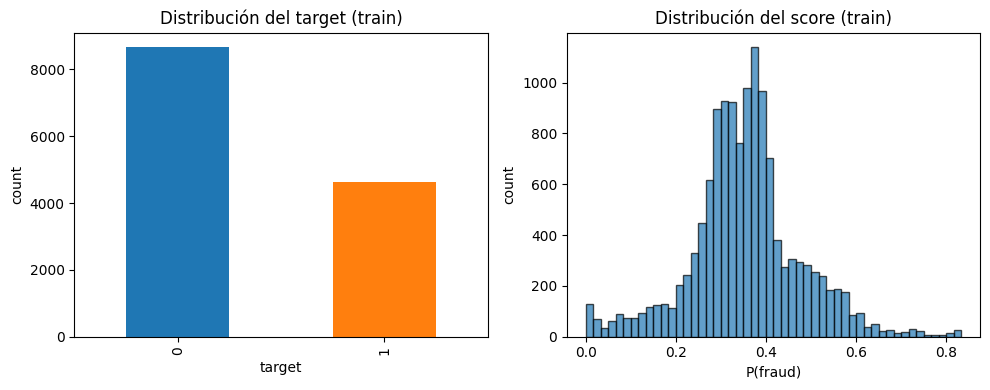

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df_train["target"].value_counts().sort_index().plot(kind="bar", ax=axes[0], color=["C0", "C1"])
axes[0].set_title("Distribución del target (train)")
axes[0].set_xlabel("target")
axes[0].set_ylabel("count")

y_score = calibrated_model.predict_proba(df_train[cols_for_model])[:, 1]
axes[1].hist(y_score, bins=50, edgecolor="black", alpha=0.7)
axes[1].set_title("Distribución del score (train)")
axes[1].set_xlabel("P(fraud)")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()